<a href="https://colab.research.google.com/github/sejin-sim/Hands_On_ML/blob/master/%5B%ED%95%B8%EC%A6%88%EC%98%A8%5D_Chapter3_%EB%B6%84%EB%A5%98(Classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. MNIST
- 고등학생과 미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지를 모은 데이터셋

In [1]:
# 셋팅
import sys
import sklearn
import numpy as np
import pandas as pd
import os
import matplotlib.font_manager as fm
import seaborn as sns
import warnings

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib.pyplot as plt 
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# warnings.filterwarnings(action='ignore') 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
plt.rcParams['axes.unicode_minus'] = False
mpl.font_manager._rebuild()

# 불필요한 경고를 무시합니다 (사이파이 이슈 #5998 참조)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()
# 사이킷런에서 읽은 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 갖고 있습니다.

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape # (70000, 784)
y.shape # (70000,)
# 이미지가 70,000개가 있고, 각 이미지에는 784개의 특성이 잇습니다.
# 이미지가 28x28 픽셀이기 때문이다. 각 특성은 0~255(흰~검정)까지의 픽셀 강도를 나타낸다.

(70000,)

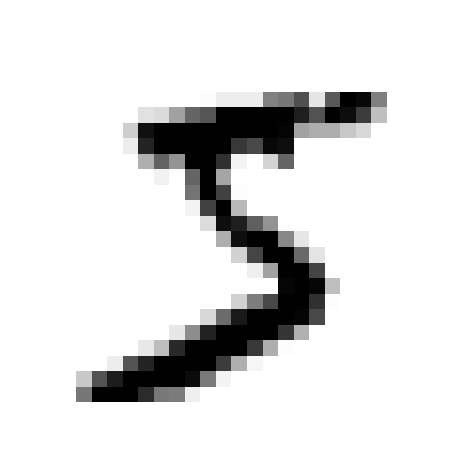

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

In [5]:
y[0] # 실제로 5다.

'5'

In [6]:
# 레이블은 문자열이다. 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환
y = y.astype(np.uint8)
y[0]

5

In [7]:
# 테스트 세트 생성
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 2. 이진 분류기 훈련
- 이진 분류기(binary classifier) : 5-감지기로 5 or 5아님

In [8]:
# 이진 분류기 훈련
y_train_5 = (y_train==5) # 5만 T, 나머지 F
y_test_5 = (y_test==5)

- 확률적 경사 하강법(Stochastic Grandien Descent. SGD) : 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문에 큰 데이터셋을 효율적으로 처리하는 장점이 있다.

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
# 모델을 사용해 숫자 5의 이미지를 감지
sgd_clf.predict([some_digit]) # 정확하게 맞췄다.

array([ True])

### 3. 성능 측정
 1) 교차검증을 사용한 정확도 측정

In [11]:
# 교차 검증 (cross_val_score())
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')
# cv = 3 : 3개의 k-겹 교차검증을 사용해 SGDClassifier 모델을 평가.
# array([0.95035, 0.96035, 0.9604 ]) Acc 95 % 이상

array([0.95035, 0.96035, 0.9604 ])

In [12]:
# 모든 이미지를 5아님 클래스로 분류하는 더미 분류기

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# 이미지의 10% 정도만 숫자 5이기 때문에 무조건 5아님으로 하면, 맞출 정확도가 90% 이상. 
# 정확도를 분류기의 측정 지표로 선호하지 않는 이유를 보여준다.

array([0.91125, 0.90855, 0.90915])

2) 오차 행렬(confusion matrix) : 분류기의 성능을 평가하는 더 좋은 방법
 - 클래스A의 샘플이 클래스 B로 분류된 횟수를 세는 것이다.
 - 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면? 5행 3열을 보면 됩니다.

In [13]:
from sklearn.model_selection import cross_val_predict

# cross_val_predict : 실제 타깃과 비교할 수 있는 예측 함수
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix

# confusion_matrix : 오차 행렬을 만드는 함수
confusion_matrix(y_train_5, y_train_pred)

# 5아님 TN 53892, FP 687
# 5임   FN 1891,  TP 3530

array([[53892,   687],
       [ 1891,  3530]])

<img src="https://2.bp.blogspot.com/-uCi_IXC-5C0/W4lDTCG8SnI/AAAAAAAABIo/kxasPdWoA107m1qazYXvHsCy6Q9h1QBSwCEwYBhgL/s1600/xxx.png"  width="700" height="300">

In [15]:
y_train_perfect_predictions = y_train_5 # 완변한척 하자
confusion_matrix(y_train_5, y_train_perfect_predictions) # 완벽한 분류기의 경우

array([[54579,     0],
       [    0,  5421]])

3) 정밀도와 재현율
- 정밀도(Precision) : 양성 예측의 정확도
> $ \Large \frac{TP} {TP + FP} $ 
- 재현율(Recall) : 분류기가 정확하게 감지한 양성 샘플의 비율
> $ \Large \frac{TP} {TP + FN} $ 

In [16]:
from sklearn.metrics import precision_score, recall_score

# 정밀도
precision_score(y_train_5, y_train_pred) # == 3530 / (3530+687) 정밀도 = 모든 양성 중 진짜 양성 비율

0.8370879772350012

In [17]:
# 재현율
recall_score(y_train_5, y_train_pred)   # == 3530 / (3530+1891) 재현율 = 진짜양성과 가짜음성 중 진짜 양성 비율

0.6511713705958311

- F1 점수 : 정밀도와 재현율의 조화 평균(harmonic mean)   
> $ \Large F_{1} = \frac{2 \cdot Precision \cdot Recall} {Precision + Recall} $    
> - 정밀도와 재현율이 비슷한 분류기에서는 $ F_{1} $ 점수가 높다.
> - 정밀도와 재현율은 트레이드 오프(Trade off) 관계이다.

In [18]:
from sklearn.metrics import f1_score

# F1 점수
f1_score(y_train_5, y_train_pred) # 정밀도와 재현율은 trad_off 관계 이다.

0.7325171197343846

4) 정밀도/재현율 트레이드오프
- 결정 함수(decision function)를 사용하여 각 샘플의 점수를 계산
- 점수가 임계값보다 크면 샘플을 양성 클래스에 할당하고, 그렇지 않으면 음성 클래스에 할당
- 결정 임계값(decision threshold)을 높게 가지면, 정밀도 ↑ & 재현율 ↓

In [19]:
# decision_function : 각 샘플의 점수를 얻을 수 있다.

y_scores = sgd_clf.decision_function([some_digit])
print(y_scores) # array([2164.22030239])

# 임계값이 0 인 경우
threshold = 0 
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred # array([ True])

[2164.22030239]


array([ True])

In [20]:
# 임계값을 높인다.
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
# 임계값을 높이면, 재현율이 줄어든다.

array([False])

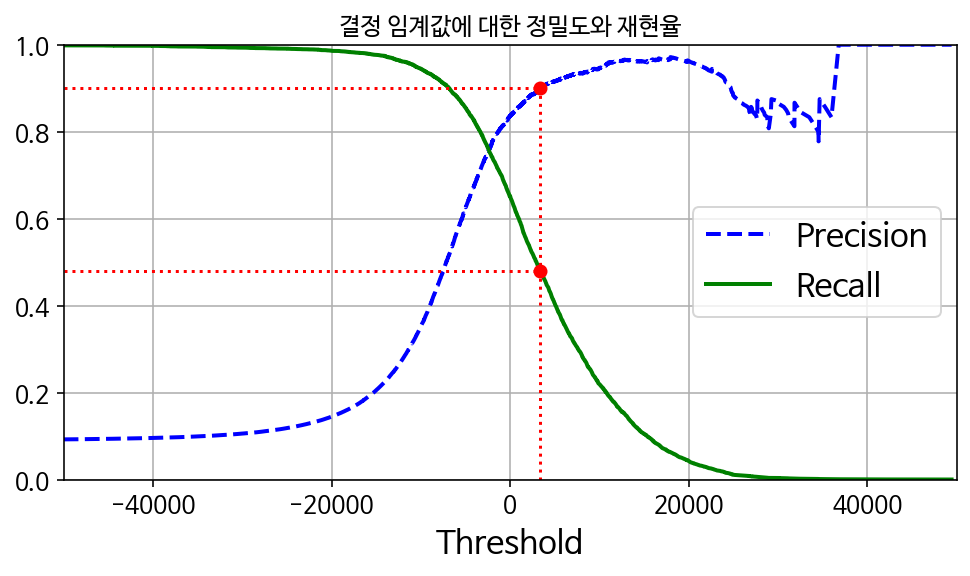

In [21]:
# 적절한 임계 값 구하기
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = "decision_function") # 결정 점수를 반환하도록 지정

from sklearn.metrics import precision_recall_curve # 가능한 모든 임계값에 대해 정밀도와 재현율을 계산

# precision_recall_curve : 모든 임계 값에 대해 정밀도와 재현율을 계산
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# 임계값 그리는 함수
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] 

plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.title("결정 임계값에 대한 정밀도와 재현율")                                                                    
plt.show()

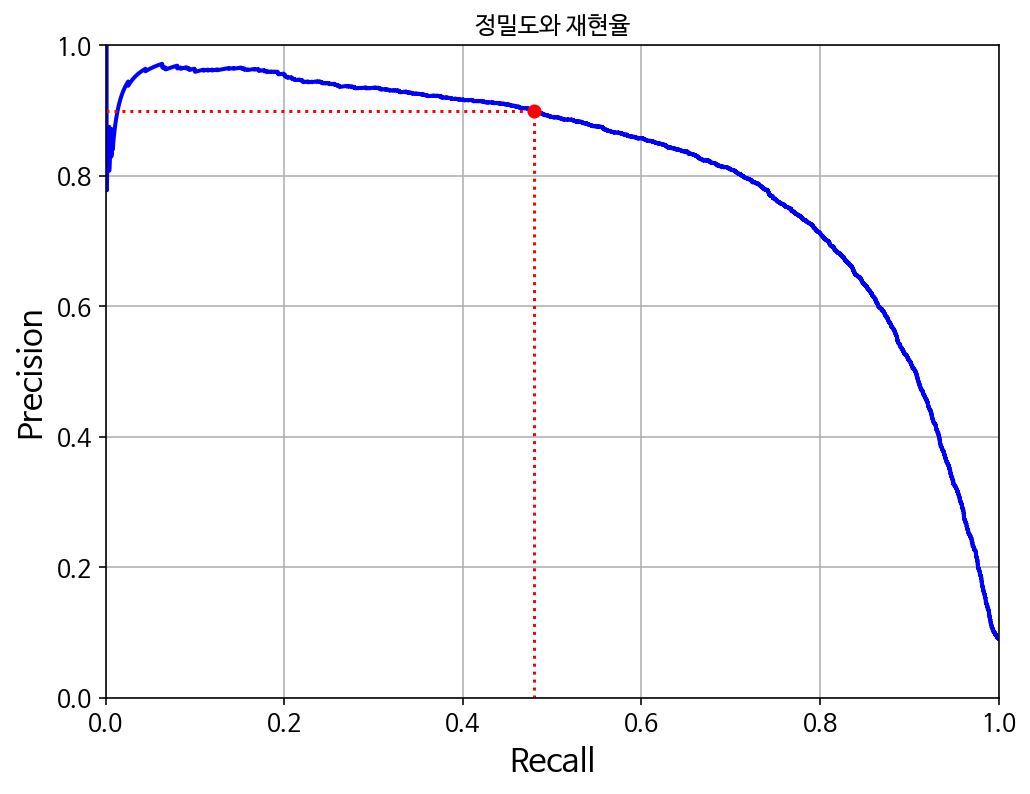

In [22]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.title("정밀도와 재현율") 
plt.show()

- 재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작한다.
- 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋다.
- 정밀도 90% 달성이 목표라면? 


In [23]:
# np.argmax는 최대값의 첫 번째 인덱스를 반환한다.
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] 
threshold_90_precision

3370.0194991439557

In [24]:
# 훈련세트에 대한 예측
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [25]:
print("정밀도 =", precision_score(y_train_5, y_train_pred_90))
print("재현율 =", recall_score(y_train_5, y_train_pred_90))
# 결론 : 정밀도 90%, 재현율 48%의 분류기를 만들었다.

정밀도 = 0.9000345901072293
재현율 = 0.4799852425751706


5) ROC 곡선 (receiver operating characteristic)
- 이진 분류에서 널리 사용하는 도구이다.
- 정밀도/재현율 곡선과 매우 비슷하지만, 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)의 곡선이다.
> $FPR = 1 - TNR$(TNR : 특이도 = 진짜 음성 비율. specificity)   
> $ TPR =$  재현율의 또 다른 이름


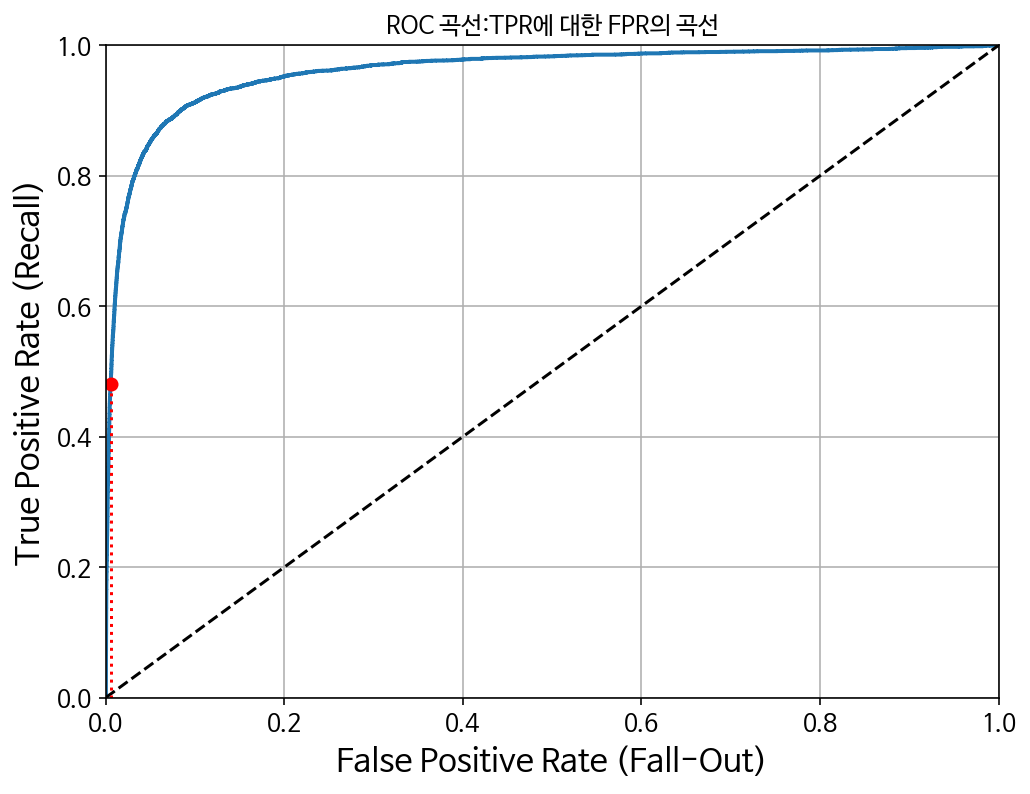

In [26]:
# ROC 곡선
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
plt.title("ROC 곡선:TPR에 대한 FPR의 곡선")                                 
plt.show()

- 재현율(TPR)이 높을 수록 거짓양성(FPR)이 늘어난다. 
- 좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 한다.(왼쪽 위 모서리)
- 곡선 아래의 면적(AUC)을 측정하면 분류기들을 비교할 수 있다.
- 완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5

In [27]:
# roc_auc_score : ROC의 AUC를 계산하는 함수
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores) # 0.9604938554008616

0.9604938554008616

- RandomForestClassifier를 훈련시켜 SGD의 ROC 곡선과 ROC AUC 점수를 비교하자!
- 먼저 훈련 세트의 샘플에 대한 점수를 얻는다.

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")# predict_proba = 주어진 클래스에 속할 확률을 담은 배열

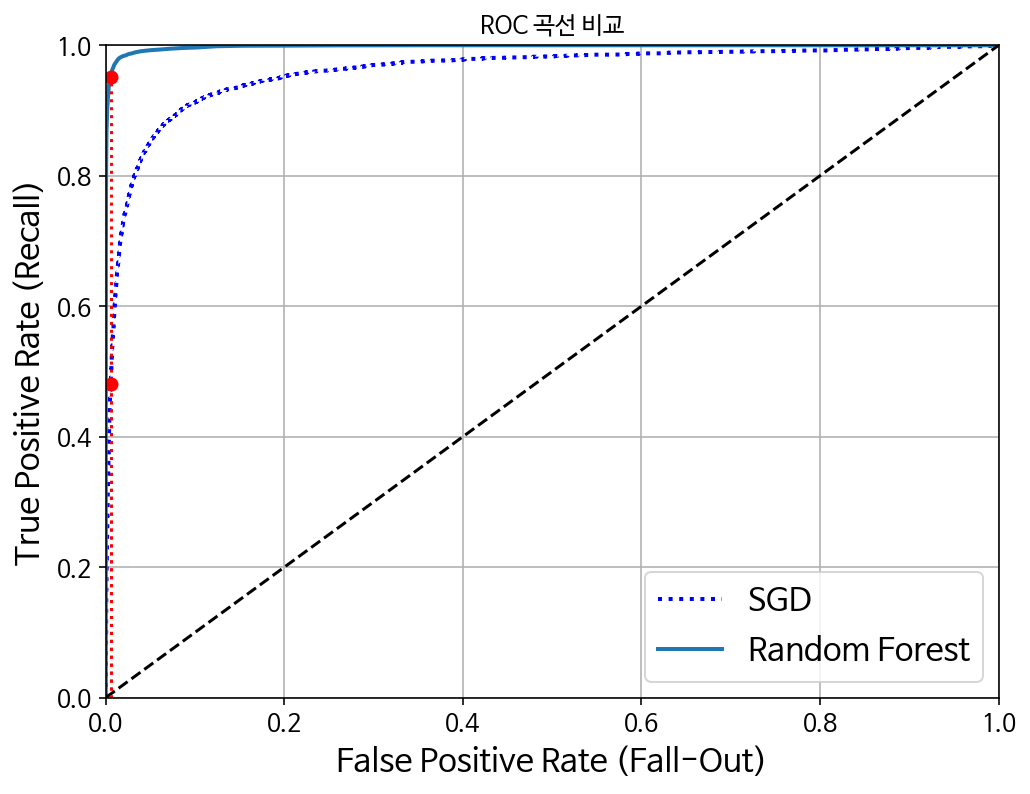

In [29]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.title("ROC 곡선 비교")
plt.show()

- RF 분류기가 SGD 분류기보다 좋음을 알 수 있다. ROC 곡선이 더 왼쪽 위 모서리에 가깝기 때문

In [30]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

- 정밀도와 재현율 점수 계산시 99.0% 정밀도 & 86.6% 재현율

### 4. 다중 분류
- 다중 분류기(multiclass classifier) : 둘 이상의 클래스 구별 가능
- OvR(one-versus-the-rest) : 특정 숫자 하나만 구분하는 이진 분류기를 훈련시켜서 10개인 숫자 이미지 분류 시스템을 만들고, 결정 점수 중에서 가장 높은 것을 클래스로 선택   
- OvO(one-versus-one) : 각 숫자의 조합마다 이진 분류기를 훈련 

In [31]:
from sklearn.svm import SVC

# 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO를 실행한다.

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train입니다
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [32]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores
# OvO 전략을 사용해 10개의 점수를 반환했다.
# 가장 높은 점수는 클래스 5에 해당 되는 값이다.

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [33]:
print(np.argmax(some_digit_scores))
# 분류기 훈련될 때 classes_ 속성에 타깃 클래스의 리스트를 값으로 정렬하여 저장함
print(svm_clf.classes_)
svm_clf.classes_[5]

5
[0 1 2 3 4 5 6 7 8 9]


5

In [34]:
from sklearn.multiclass import OneVsRestClassifier

# OvR 전략 사용하는 다중 분류기
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
print(ovr_clf.predict([some_digit]))
len(ovr_clf.estimators_)

[5]


10

In [35]:
# SGD Clf 
sgd_clf.fit(X_train, y_train)
print(sgd_clf.predict([some_digit]))
sgd_clf.decision_function([some_digit])
# array([3], dtype=uint8)
# array([[-31893.03095419, -34419.69069632,  -9530.63950739,
#           1823.73154031, -22320.14822878,  -1385.80478895,
#         -26188.91070951, -16147.51323997,  -4604.35491274,
#         -12050.767298  ]])

[3]


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [36]:
# SGD Clf 정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
# array([0.87365, 0.85835, 0.8689 ])

array([0.87365, 0.85835, 0.8689 ])

In [37]:
from sklearn.preprocessing import StandardScaler 
# 간단한 입력의 스케일 조정으로 정확도 높일 수 있다.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
# array([0.8983, 0.891 , 0.9018])

array([0.8983, 0.891 , 0.9018])

### 5. 에러 분석
- 가능성이 높은 모델을 하나 찾았다고 가정하고, 이 모델의 성능을 향상 시킬 방법을 찾자
- 오차 행렬을 통해 살펴 보자

In [38]:
# cross_val_predict로 예측을 만들고 confusion_matrix 호출
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

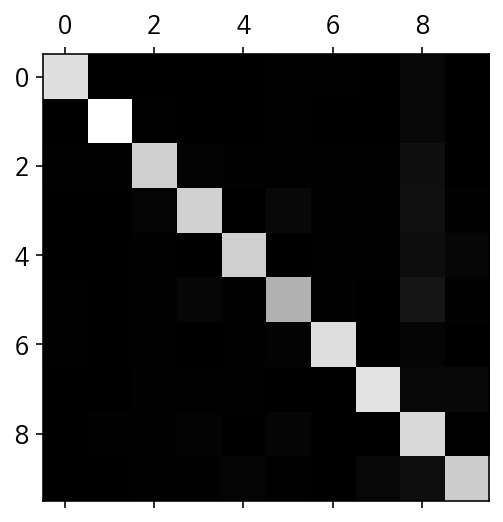

In [39]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

- 이 오차 행렬은 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아 보인다.
- 숫자 5는 다른 숫자보다 조금 더 어두워 보임 = 숫자 5의 이미지가 적거나, 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻
- 그래프의 에러 부분에 초점을 맞추어 에러 비율을 비교한다. ↓

In [40]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

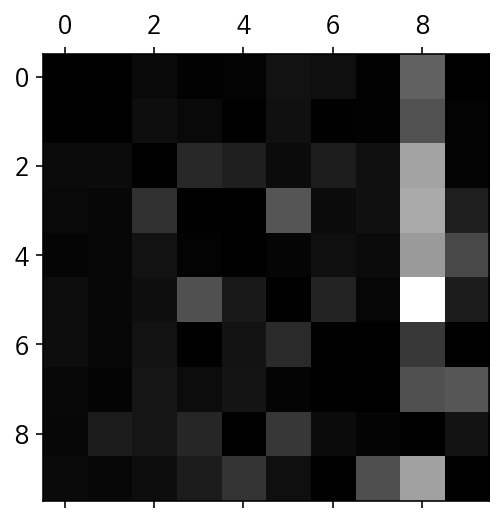

In [41]:
# fill_diagonal : 주 대각선만 0으로 채운다.
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- 클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시한다.
- 하지만 클래스 8의 행은 나쁘지 않다.
- 오차 행렬은 반드시 대칭인 것은 아니다.

In [42]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

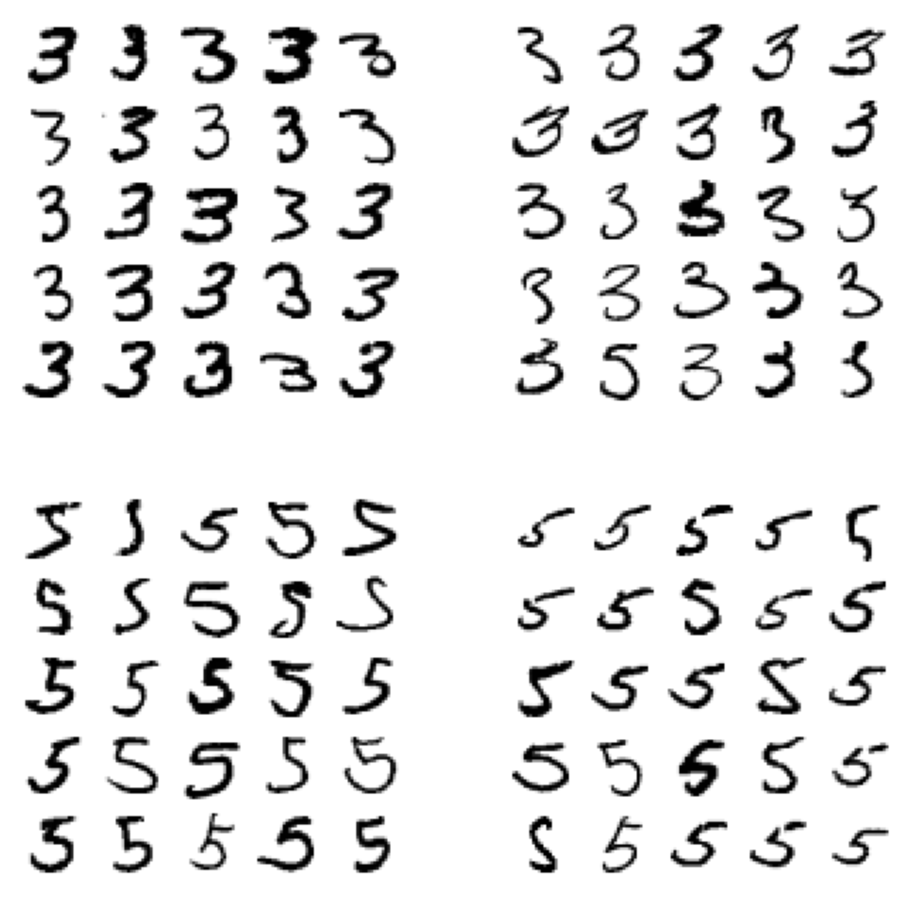

In [43]:
# 3과 5의 샘플을 그려보자

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

- 선형 분류기는 각 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도와 가중치 합을 클래스의 점수로 계산한다.
- 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동하게 된다.

<br/>

### 6. 다중 레이블 분류
- 다중 레이블 분류 시스템 : 여러개의 이진 꼬리표를 출력하는 분류 시스템

In [44]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)    # 7 이상의 큰 숫자인지?
y_train_odd = (y_train % 2 == 1)  # 홀 수 인지?
y_multilabel = np.c_[y_train_large, y_train_odd] # 두 개의 타깃 레이블이 담긴 배열

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel) # 다중 타깃 배열을 이용하여 훈련시킨다.

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [45]:
knn_clf.predict([some_digit])
# 올바르게 분류 되었다. 숫자는 크지 않고 홀수이다.

array([[False,  True]])

In [46]:
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# f1_score(y_multilabel, y_train_knn_pred, average="macro")

### 7. 다중 출력 분류
- 다중 출력 다중 클래스 분류(multioutput-multiclass classification) : 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있또록 일반화 한 것
- 이미지에서 잡음을 제거하는 시스템을 만들어 보겠다.

In [48]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

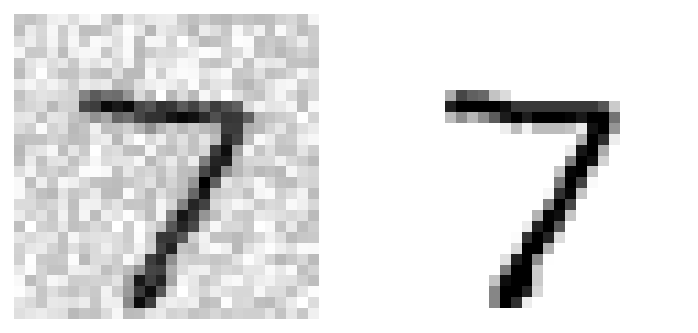

In [49]:
# randint : 픽셀 강도에 잡음을 추가. 타깃 이미지는 원본 이미지가 된다.
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

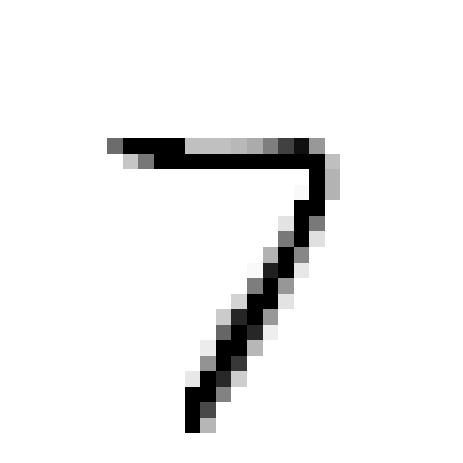

In [50]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)